In [1]:
import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import utile_labels

import keras_ocr

tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

tf.config.list_physical_devices('GPU')

# tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
dataset_labels = utile_labels.get_labels_tot_and_noise()[:-300]
print("Dataset len:", len(dataset_labels))
dataset_labels[:2]

Dataset len: 23418


[('image_dataset_noise/noise_gauss_img_10.png', None, 'am'),
 ('image_dataset_noise/noise_median_img_10.png', None, 'am')]

In [4]:
test_labels =  utile_labels.get_labels_tot_and_noise()[23518:]
print("Test len:", len(test_labels))
test_labels[:2]

Test len: 200


[('image_dataset/img_9746.png', None, 'michela'),
 ('image_dataset/img_9747.png', None, 'tessera')]

In [5]:
# recognizer_alphabet = recognizer.alphabet
# recognizer_alphabet = recognizer_alphabet[:12] + './-()'+recognizer_alphabet[12:]
# recognizer_alphabet
alphabet = ' 0123456789ab./-()cdefghijklmnopqrstuvwxyz'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
recognizer_alphabet

' ()-./0123456789abcdefghijklmnopqrstuvwxyz'

In [6]:
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()

Instructions for updating:
Colocations handled automatically by placer.
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Computer\.keras-ocr\crnn_kurapan_notop.h5


In [7]:
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(dataset_labels, test_size=0.2, random_state=42)

print("Train len:", len(train_labels))
print("Train example:", train_labels[:2])
print("Validation len", len(validation_labels))


Train len: 18734
Train example: [('image_dataset/img_6859.png', None, '13.07.1959'), ('image_dataset/img_5765.png', None, 'diresidenza')]
Validation len 4684


In [8]:
batch_size = 32

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer_alphabet,
            # augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]

In [9]:
print(training_image_gen, training_steps)
print(validation_image_gen, validation_steps)

<generator object get_recognizer_image_generator at 0x00000249AF2B5F50> 585
<generator object get_recognizer_image_generator at 0x00000249AF2B4350> 146


In [10]:
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: 06


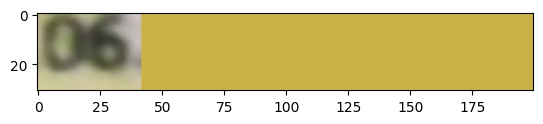

In [11]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

text: 170


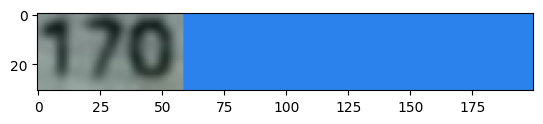

In [12]:
image, text = next(validation_image_gen)
print('text:', text)
_ = plt.imshow(image)

In [13]:
# RECOGNIZER LOAD_MODEL / FIT
# recognizer.model = tf.keras.models.load_model('modelli_allenati/recogn_model_colab_05')

callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('checkpoints', monitor='val_loss', save_best_only=True, save_freq='epoch'),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=150,
)

Epoch 1/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 7.6821

c:\Users\Computer\anaconda3\envs\condomini-env\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 172s 275ms/step - batch: 292.0000 - size: 8.0000 - loss: 7.6821 - val_loss: 2.6826
Epoch 2/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 2.4557

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 157s 268ms/step - batch: 292.0000 - size: 8.0000 - loss: 2.4557 - val_loss: 2.1268
Epoch 3/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.8176

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 159s 271ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.8176 - val_loss: 1.4791
Epoch 4/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.4649

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 158s 271ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.4649 - val_loss: 1.3606
Epoch 5/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.1927

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 159s 271ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.1927 - val_loss: 1.2040
Epoch 6/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.1366

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 158s 271ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.1366 - val_loss: 1.0954
Epoch 7/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.0766 - val_loss: 1.2957
Epoch 8/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.8998

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 159s 271ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.8998 - val_loss: 0.8010
Epoch 9/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.8265 - val_loss: 0.9546
Epoch 10/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.8500

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 156s 267ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.8500 - val_loss: 0.7293
Epoch 11/150
585/585 [==============================] - 143s 244ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.9148 - val_loss: 1.8324
Epoch 12/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 2.1049 - val_loss: 1.8355
Epoch 13/150
585/585 [==============================] - 143s 245ms/step - batch: 292.0000 - size: 8.0000 - loss: 2.6115 - val_loss: 5.6794
Epoch 14/150
585/585 [==============================] - 142s 242ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.9475 - val_loss: 6.0491
Epoch 15/150
585/585 [==============================] - 141s 242ms/step - batch: 292.0000 - size: 8.0000 - loss: 7.3599 - val_loss: 1.2069
Epoch 16/150
585/585 [==============================] - 144s 246ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.7489 - val_loss: 0.7577
Epoch 17/150
585/585 [==================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 157s 269ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.5902 - val_loss: 0.7195
Epoch 20/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.5683

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 158s 270ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.5683 - val_loss: 0.6773
Epoch 21/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.6332

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 157s 268ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.6332 - val_loss: 0.5523
Epoch 22/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.5089

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 157s 269ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.5089 - val_loss: 0.5176
Epoch 23/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.4818

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 157s 268ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4818 - val_loss: 0.5045
Epoch 24/150
585/585 [==============================] - 144s 246ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.5105 - val_loss: 0.5781
Epoch 25/150
585/585 [==============================] - 147s 251ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4802 - val_loss: 0.5404
Epoch 26/150
585/585 [==============================] - 146s 249ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3791 - val_loss: 0.6008
Epoch 27/150
585/585 [==============================] - 146s 249ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4187 - val_loss: 0.5343
Epoch 28/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4910 - val_loss: 0.7266
Epoch 29/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.3932

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 155s 264ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3932 - val_loss: 0.4226
Epoch 30/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.3433

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 156s 266ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3433 - val_loss: 0.4224
Epoch 31/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4082 - val_loss: 0.4367
Epoch 32/150
585/585 [==============================] - 141s 241ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4050 - val_loss: 0.5757
Epoch 33/150
585/585 [==============================] - 141s 242ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3672 - val_loss: 0.5943
Epoch 34/150
585/585 [==============================] - 141s 241ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3262 - val_loss: 0.4965
Epoch 35/150
585/585 [==============================] - 142s 242ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4029 - val_loss: 0.5379
Epoch 36/150
585/585 [==============================] - 141s 241ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3130 - val_loss: 0.4979
Epoch 37/150
585/585 [==================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 152s 260ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3553 - val_loss: 0.4113
Epoch 40/150
585/585 [==============================] - 139s 237ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2792 - val_loss: 0.4165
Epoch 41/150
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.3215

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 157s 269ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3215 - val_loss: 0.3383
Epoch 42/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3294 - val_loss: 0.7648
Epoch 43/150
585/585 [==============================] - 144s 247ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3054 - val_loss: 0.4767
Epoch 44/150
585/585 [==============================] - 144s 246ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2662 - val_loss: 0.4342
Epoch 45/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3029 - val_loss: 0.3927
Epoch 46/150
585/585 [==============================] - 143s 245ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2673 - val_loss: 0.6339
Epoch 47/150
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2853 - val_loss: 0.6282
Epoch 48/150
585/585 [==================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 171s 292ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2465 - val_loss: 0.3068
Epoch 72/150
585/585 [==============================] - 154s 263ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2333 - val_loss: 0.4323
Epoch 73/150
585/585 [==============================] - 155s 265ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2576 - val_loss: 0.3214
Epoch 74/150
585/585 [==============================] - 158s 269ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2062 - val_loss: 0.3543
Epoch 75/150
585/585 [==============================] - 156s 267ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2233 - val_loss: 0.5633
Epoch 76/150
585/585 [==============================] - 155s 265ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2313 - val_loss: 0.4374
Epoch 77/150
585/585 [==============================] - 145s 247ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2736 - val_loss: 0.8103
Epoch 78/150
585/585 [==================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 163s 280ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2066 - val_loss: 0.2801
Epoch 92/150
585/585 [==============================] - 152s 260ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2364 - val_loss: 0.5734
Epoch 93/150
585/585 [==============================] - 153s 262ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.1995 - val_loss: 0.4503
Epoch 94/150
585/585 [==============================] - 154s 263ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2323 - val_loss: 0.5052
Epoch 95/150
585/585 [==============================] - 153s 261ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.1905 - val_loss: 0.3838
Epoch 96/150
585/585 [==============================] - 152s 260ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2278 - val_loss: 0.6015
Epoch 97/150
585/585 [==============================] - 153s 261ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2119 - val_loss: 0.4538
Epoch 98/150
585/585 [==================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 169s 290ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.1948 - val_loss: 0.2623
Epoch 130/150
585/585 [==============================] - 156s 266ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.1946 - val_loss: 0.5391
Epoch 131/150
585/585 [==============================] - 149s 256ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2162 - val_loss: 0.5106
Epoch 132/150
585/585 [==============================] - 153s 262ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.1494 - val_loss: 0.3164
Epoch 133/150
585/585 [==============================] - 153s 262ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2210 - val_loss: 0.5559
Epoch 134/150
585/585 [==============================] - 154s 264ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2291 - val_loss: 0.4528
Epoch 135/150
585/585 [==============================] - 154s 263ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2184 - val_loss: 0.5907
Epoch 136/150
585/585 [===========

In [30]:
# Save the weights
recognizer.model.save_weights('./weights2/')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./weights')

# Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

c:\Users\Computer\anaconda3\envs\condomini-env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted: surname, Actual: surname


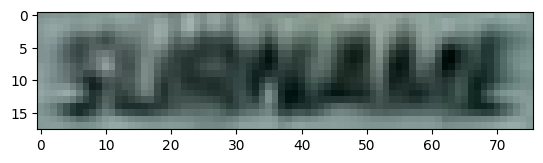

In [15]:
image_filepath, _, actual = test_labels[np.random.randint(0,  len(test_labels))]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [16]:
import cv2

Looking for C:\Users\Computer\.keras-ocr\craft_mlt_25k.h5


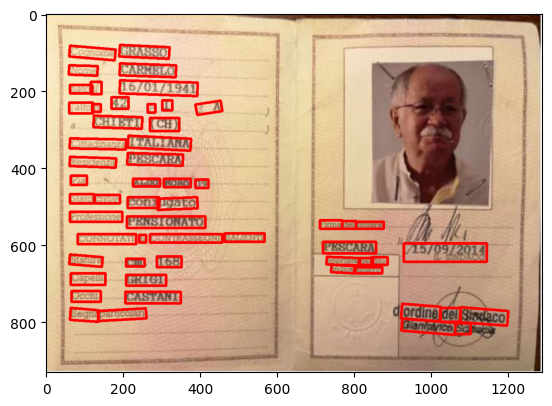

In [26]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
pathFile = 'documenti_test\identitaVecchia_interno_grasso.jpg'
# Original Image -> label Detector

image_original = keras_ocr.tools.read(pathFile)

boxes_orignial = detector.detect(images=[image_original])[0]

drawn = keras_ocr.tools.drawBoxes(image=image_original, boxes=boxes_orignial)

plt.imshow(drawn)

In [27]:
array = []
for idx,box in enumerate(boxes_orignial) :
    # Trasforma array in INT
    box = box.astype('int64')
    # Ritaglia bounding-box corrente da immagine...
    parola_cropped = image_original[box[0][1]:box[2][1], box[0][0]:box[2][0] ]
    cv2.imwrite("temp.png", parola_cropped)
    img_cropped = cv2.imread('temp.png')
    array.append(recognizer.recognize(img_cropped))
print(array)

['grasso', 'cognome', 'carmelo', 'nome', '16/01/1941', 'l', 'nato', '42', 'i', '(eca', '(atto', 'vi', 'p', 'chieti', '(ch)', 'italiana', 'cittadinanza', 'pescara', 'regidenza', 'via', 'aldo', 'moro', '39', 'stato', 'civile', 'coni', 'ugato', 'professione', 'pensionato', 'firma', 'den', 'diolaro', 'salienti', 'connotati', 'contrassegni', 'e', 'pescara', 'd15/09/2014', 'statura', '168', 'impronta', 'dito', 'del', 'cit', 'indice', 'binistro', 'capelli', 'grigi', 'occhi', 'castani', 'ordine', 'segni', 'del', 'sinaco', 'particolari', 'gianfadica', 'sca']


In [19]:
recognizer2 = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer2.model = tf.keras.models.load_model('checkpoints')
recognizer2.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Computer\.keras-ocr\crnn_kurapan_notop.h5


SystemError: unknown opcode

In [ ]:
array = []
for idx,box in enumerate(boxes_orignial) :
    # Trasforma array in INT
    box = box.astype('int64')
    # Ritaglia bounding-box corrente da immagine...
    parola_cropped = image_original[box[0][1]:box[2][1], box[0][0]:box[2][0] ]
    cv2.imwrite("temp.png", parola_cropped)
    img_cropped = cv2.imread('temp.png')
    array.append(recognizer2.recognize(img_cropped))
print(array)

In [ ]:
# recognizer.model.save('modelli_all/recognizer_model')

INFO:tensorflow:Assets written to: modelli_allenati/recognizer_model\assets


INFO:tensorflow:Assets written to: modelli_allenati/recognizer_model\assets


In [35]:
recognizerTraining = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizerUntrained = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizerTraining.compile()
recognizerUntrained.compile()
# recognizer.model.summary()
recognizerTraining.model.load_weights('checkpoints')

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Computer\.keras-ocr\crnn_kurapan_notop.h5


Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Computer\.keras-ocr\crnn_kurapan_notop.h5


In [36]:
arrayTraining = []
arrayUntrained = []
for idx,box in enumerate(boxes_orignial) :
    # Trasforma array in INT
    box = box.astype('int64')
    # Ritaglia bounding-box corrente da immagine...
    parola_cropped = image_original[box[0][1]:box[2][1], box[0][0]:box[2][0] ]
    cv2.imwrite("temp.png", parola_cropped)
    img_cropped = cv2.imread('temp.png')
    arrayTraining.append(recognizerTraining.recognize(img_cropped))
    arrayUntrained.append(recognizerUntrained.recognize(img_cropped))
print(arrayTraining)
print('non addestrato:\n')
print(arrayUntrained)

c:\Users\Computer\anaconda3\envs\condomini-env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


['grasso', 'cognome', 'carmelo', 'nome', '16/01/1941', 'l', 'nato', '42', 'i', 'oa', '(atto', 'i.', 'p', 'chieti', '(ch)', 'italiana', 'cittadinanza', 'pescara', 'residenza', 'via', 'aldo', 'moro', '39', 'stato', 'civile', 'coni', 'ugato', 'professione', 'pensionato', 'firma', 'del', 'lilolaro', 'salienti', 'connotati', 'contrassegni', 'e', 'pescara', '15/09/2014', 'statura', '168', 'impronta', 'dito', 'del', 'ctt', 'indioe', 'ainiatro', 'capelli', 'grigi', 'occhi', 'castani', 'ordine', 'segni', 'del', 'sinaco', 'particolari', 'giaonfaca', 'sca']
non addestrato:

['f7pnknfpfz1u)utfv', 'fp0k32p)p7pfv', 'fpnpfkf3pfpf2)uf0v', 'f7np7f0)pfp02pf0fv0v', 'fsfs6fsf6fs', 'f67f6760f0v', 'f7pf7kfpfp3tpfv0v', 'f67s6fsf0v', 'f57fs76720v', 'f7fnpfnf0nv', 'f7kpf)32fv0v', 'f7s7f76f0v', 'f57k70v', 'f0k0fpufi/f0v', 'f7fnk70fp02f0v', 'fpnpnpfpfp6f0v', 'fnfk7fkfm/nfnv', 'fn7ktpf)pf0nv', 'fnpn2p7fpfm0nf0nv', 'f7ntfpf0f0v', 'f7nf0usf0v', 'f7f73tpf)upfv0vnv', 'f6s1s6fsf0v', 'f7npftfpf23tsfv0v', 'f7n0k3pf)pips